## 1. Environment & Hardware Verification
To perform efficient fine-tuning of **ESM-2** using **LoRA** and **RL**, a GPU is required to handle the high-dimensional tensor operations and gradient calculations.

* **Tool:** `nvidia-smi` (NVIDIA System Management Interface)
* **Purpose:** Confirms the presence of a CUDA-enabled device and monitors VRAM availability.
* **Safety Check:** If no GPU is detected, the script terminates execution to prevent slow CPU processing or Out-Of-Memory (OOM) errors.

In [1]:
import subprocess
import sys

print("Checking GPU availability...")
try:
    gpu_info = subprocess.check_output(['nvidia-smi'], text=True)
    print(" GPU detected!")
    print(gpu_info.split('\n')[8])  
except:
    print(" WARNING: No GPU detected! This notebook requires a GPU.")
    print("Go to Runtime > Change runtime type > Select 'T4 GPU'")
    sys.exit(1)

Checking GPU availability...
 GPU detected!
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |


## 2. Dependency Installation
This project utilizes the Hugging Face ecosystem and Meta's FAIR-ESM tools to implement a parameter-efficient training pipeline.

| Library | Primary Function |
| :--- | :--- |
| **transformers** | Provides the pre-trained ESM-2 model architecture and tokenizers. |
| **peft** | Implements **LoRA**, enabling the tuning of a fraction (~1%) of model parameters. |
| **accelerate** | Handles device placement and distributed training optimizations. |
| **fair-esm** | Native Meta AI tools for working with Evolutionary Scale Modeling (ESM) weights. |
| **wandb** | Used for experiment tracking and visualizing multi-objective reward trade-offs. |

In [2]:

!pip install -q transformers>=4.41.0 peft==0.7.1 accelerate==0.25.0
!pip install -q datasets wandb
!pip install -q fair-esm

print(" All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.5 MB/s eta 0:00:00
 All packages installed successfully!


In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, get_cosine_schedule_with_warmup
from peft import LoraConfig, get_peft_model, TaskType
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import wandb
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


In [4]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")
if torch.cuda.is_available():
    print(f"GPU:{torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


using device: cuda
GPU:Tesla T4
Memory: 15.83 GB


In [6]:
import wandb

wandb.login(key="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")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manivarshithpc (manivarshithpc-vignan-institute-of-technology-and-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 3. Global Configuration & Experiment Setup
This section defines the architectural and behavioral parameters for the fine-tuning process. We utilize a structured `Config` class to ensure all hyperparameters are tracked.

### Key Components:
* **Model Backbone:** `ESM-2 (650M parameters)` - A large-scale protein language model.
* **LoRA Strategy:** Targets the **Self-Attention** modules (`q, k, v`) to adapt sequence generation with minimal parameter updates.
* **RL Steering:** * **KL Coefficient:** Controls the trade-off between exploring new sequences and staying close to the biologically-valid base model.
    * **Reward Weights:** A weighted sum approach to balance **Stability** (structural integrity), **Diversity** (novelty), and **Constraint Satisfaction**.
* **Logging:** Integrated with **Weights & Biases (WandB)** for real-time monitoring of reward convergence and sequence entropy.

In [7]:
@dataclass
class Config:
    
    model_name: str = "facebook/esm2_t33_650M_UR50D"  
    
    # LoRA configuration
    lora_r: int = 8
    lora_alpha: int = 16
    lora_dropout: float = 0.05
    lora_target_modules: List[str] = None
    
    # Generation configuration
    max_seq_length: int = 64
    min_seq_length: int = 32
    temperature: float = 1.0
    top_k: int = 50
    top_p: float = 0.9
    
    # RL training configuration
    num_epochs: int = 5
    batch_size: int = 4
    gradient_accumulation_steps: int = 4
    num_sequences_per_batch: int = 8
    learning_rate: float = 5e-5
    kl_coef: float = 0.1  # KL penalty coefficient
    clip_range: float = 0.2  
    
    # Reward weights
    stability_weight: float = 1.0
    diversity_weight: float = 0.5
    constraint_weight: float = 0.5
    
    # Optimizer
    adam_epsilon: float = 1e-8
    max_grad_norm: float = 1.0
    warmup_steps: int = 100
    
    
    log_interval: int = 10
    save_interval: int = 100
    use_wandb: bool = True
    
    def __post_init__(self):
        if self.lora_target_modules is None:
            self.lora_target_modules = ["query", "key", "value"]

config = Config()


import gc
torch.cuda.empty_cache()
gc.collect()

print(f"\n Configuration loaded")
print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


if config.use_wandb:
    wandb.init(
        project="protein-rl-design",
        config=vars(config),
        name="esm2-rl-experiment"
    )


 Configuration loaded
GPU Memory Available: 15.83 GB


## 4. Model Initialization & LoRA Adaptation
This section loads the ESM-2 weights and configures the **Parameter-Efficient Fine-Tuning (PEFT)** setup.

### Dual-Model Architecture:
1.  **Active Model (Actor):** The `base_model` integrated with **LoRA** adapters. This is the only part of the network that will undergo gradient updates.
2.  **Reference Model:** A frozen copy of the original ESM-2. It is used to calculate the **KL Penalty**, ensuring the RL agent remains within the manifold of biologically plausible sequences.

### Efficiency Optimizations:
* **FP16 Precision:** Reduces memory consumption to fit the 650M parameter model on a single GPU.
* **LoRA Injection:** Targets the Query, Key, and Value matrices, allowing the model to adapt its attention patterns toward desired structural traits with <1% trainable parameters.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
print(f"Vocabulary size: {len(tokenizer)}")


base_model = AutoModelForMaskedLM.from_pretrained(
    config.model_name,
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True
)

base_model = base_model.to(device)

print(f"\nBase model parameters: {sum(p.numel() for p in base_model.parameters()) / 1e6:.2f}M")

# Configure LoRA 
lora_config = LoraConfig(
    r=config.lora_r,
    lora_alpha=config.lora_alpha,
    target_modules=config.lora_target_modules,
    lora_dropout=config.lora_dropout,
    bias="none",
)


model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()


ref_model = AutoModelForMaskedLM.from_pretrained(
    config.model_name,
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True
)
ref_model = ref_model.to(device)
ref_model.eval()
for param in ref_model.parameters():
    param.requires_grad = False

print("\n Models loaded successfully!")

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Vocabulary size: 33


config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]


Base model parameters: 651.04M
trainable params: 2,027,520 || all params: 653,070,774 || trainable%: 0.3104594602483314

 Models loaded successfully!


In [9]:
print("ESM-2 Tokenizer Inspection")
print("=" * 80)
print(f"Vocabulary size: {len(tokenizer)}")
print(f"\nSpecial tokens:")
print(f"  CLS token: '{tokenizer.cls_token}' (ID: {tokenizer.cls_token_id})")
print(f"  PAD token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")
print(f"  EOS token: '{tokenizer.eos_token}' (ID: {tokenizer.eos_token_id})")
print(f"  MASK token: '{tokenizer.mask_token}' (ID: {tokenizer.mask_token_id})")

print(f"\nFirst 33 tokens:")
for i in range(len(tokenizer)):
    token = tokenizer.convert_ids_to_tokens(i)
    print(f"  ID {i:2d}: {token}")
print("=" * 80)

ESM-2 Tokenizer Inspection
Vocabulary size: 33

Special tokens:
  CLS token: '<cls>' (ID: 0)
  PAD token: '<pad>' (ID: 1)
  EOS token: '<eos>' (ID: 2)
  MASK token: '<mask>' (ID: 32)

First 33 tokens:
  ID  0: <cls>
  ID  1: <pad>
  ID  2: <eos>
  ID  3: <unk>
  ID  4: L
  ID  5: A
  ID  6: G
  ID  7: V
  ID  8: S
  ID  9: E
  ID 10: R
  ID 11: T
  ID 12: I
  ID 13: D
  ID 14: P
  ID 15: K
  ID 16: Q
  ID 17: N
  ID 18: F
  ID 19: Y
  ID 20: M
  ID 21: H
  ID 22: W
  ID 23: C
  ID 24: X
  ID 25: B
  ID 26: U
  ID 27: Z
  ID 28: O
  ID 29: .
  ID 30: -
  ID 31: <null_1>
  ID 32: <mask>


## 5. Autoregressive Protein Generation
Since **ESM-2** is natively a Masked Language Model, this module implements a custom generation wrapper to enable **de novo** protein design through iterative token prediction.

### Key Sampling Techniques:
* **Top-K Filtering:** Restricts sampling to the $K$ most likely next amino acids to prevent high-error transitions.
* **Top-P (Nucleus) Sampling:** Dynamically chooses the smallest set of tokens whose cumulative probability exceeds threshold $P$, balancing diversity and structural validity.
* **Log-Probability Tracking:** Crucial for the **Policy Gradient** updates in Reinforcement Learning, allowing the agent to correlate specific sequence choices with resulting rewards.

### Generation Workflow:
1.  **Initialize:** Start with the `[CLS]` token.
2.  **Predict:** Generate logits for the next amino acid position.
3.  **Filter & Sample:** Apply temperature, Top-K, and Top-P to select the next token.
4.  **Iterate:** Append the token and repeat until `max_length` or `[EOS]` is reached.

In [10]:
class ProteinGenerator:
    """Handles autoregressive protein sequence generation"""
    
    def __init__(self, model, tokenizer, config):
        self.model = model
        self.tokenizer = tokenizer
        self.config = config
        self.device = next(model.parameters()).device
        
        
        self.cls_token_id = tokenizer.cls_token_id
        self.eos_token_id = tokenizer.eos_token_id
        self.pad_token_id = tokenizer.pad_token_id
        self.mask_token_id = tokenizer.mask_token_id if hasattr(tokenizer, 'mask_token_id') else None
        
        self.valid_token_ids = list(range(4, 24))  
        
        self.valid_token_ids = torch.tensor(self.valid_token_ids, dtype=torch.long, device=self.device)
        
        print(f"\n{'='*80}")
        print(f"ProteinGenerator initialized")
        print(f"  Total vocabulary size: {len(tokenizer)}")
        print(f"  Valid amino acid tokens: {len(self.valid_token_ids)}")
        print(f"  Valid token IDs: {self.valid_token_ids.tolist()}")
        
        
        valid_tokens_str = [tokenizer.convert_ids_to_tokens(i) for i in self.valid_token_ids.tolist()]
        print(f"  Allowed amino acids: {', '.join(valid_tokens_str)}")
        print(f"{'='*80}\n")
        
    def generate_sequences(
        self, 
        num_sequences: int,
        temperature: float = None,
        max_length: int = None,
        return_log_probs: bool = True
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], List[str]]:
        """Generate protein sequences autoregressively"""
        temperature = temperature or self.config.temperature
        max_length = max_length or self.config.max_seq_length
        
        self.model.eval()
        
       
        sequences = torch.full(
            (num_sequences, 1), 
            self.cls_token_id, 
            dtype=torch.long, 
            device=self.device
        )
        
        log_probs_list = []
        
        with torch.no_grad():
            for step in range(max_length - 1):
                outputs = self.model(sequences)
                logits = outputs.logits[:, -1, :] 
                
                
                valid_logits = torch.full_like(logits, float('-inf'))
                
                
                valid_logits[:, self.valid_token_ids] = logits[:, self.valid_token_ids]
                
                
                valid_logits = valid_logits / temperature
                
                
                valid_logits = self._top_k_top_p_filtering(
                    valid_logits, 
                    self.config.top_k, 
                    self.config.top_p
                )
                
                
                if torch.isnan(valid_logits).any() or torch.isinf(valid_logits).all():
                    print(f"Warning: Invalid logits detected at step {step}")
                    valid_logits = torch.nan_to_num(valid_logits, nan=-1e9, posinf=1e9, neginf=-1e9)
                
                probs = F.softmax(valid_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
                
                max_token_id = next_token.max().item()
                if max_token_id >= len(self.tokenizer):
                    raise ValueError(
                        f"Generated invalid token ID {max_token_id} "
                        f"(vocab size: {len(self.tokenizer)})"
                    )
                
                if return_log_probs:
                    log_prob = F.log_softmax(valid_logits, dim=-1)
                    selected_log_probs = log_prob.gather(1, next_token)
                    log_probs_list.append(selected_log_probs)
                
                sequences = torch.cat([sequences, next_token], dim=1)
        
        log_probs = torch.cat(log_probs_list, dim=1) if (return_log_probs and log_probs_list) else None
        
        
        sequences_str = self.tokenizer.batch_decode(sequences, skip_special_tokens=True)
        
        return sequences, log_probs, sequences_str
    
    def _top_k_top_p_filtering(self, logits, top_k=0, top_p=1.0):
        if top_k > 0:
            top_k = min(top_k, logits.size(-1))
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = float('-inf')
        
        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            
            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            logits[indices_to_remove] = float('-inf')
        
        return logits


In [11]:
torch.cuda.empty_cache()


generator = ProteinGenerator(model, tokenizer, config)


print("\n" + "="*80)
print("Testing Fixed Generator (Standard Amino Acids Only)")
print("="*80)

try:
    test_sequences, test_log_probs, test_str = generator.generate_sequences(
        num_sequences=3, 
        max_length=20,
        return_log_probs=True
    )
    print(f" Successfully generated {len(test_str)} sequences!")
    print(f"\nGenerated sequences:")
    for i, seq in enumerate(test_str):
        print(f"  {i+1}. {seq} (length: {len(seq)})")
    

    print(f"\nVerifying sequences contain only standard amino acids...")
    standard_aas = set('LAGVSERTIDPKQNFYMHWC')
    all_valid = True
    for seq in test_str:
        seq_chars = set(seq.replace(' ', ''))
        if not seq_chars.issubset(standard_aas):
            print(f"  Found invalid characters: {seq_chars - standard_aas}")
            all_valid = False
    
    if all_valid:
        print(f" All sequences contain only standard amino acids!")
    
    print("="*80)
except Exception as e:
    print(f" Error during generation: {e}")
    import traceback
    traceback.print_exc()
    print("="*80)

print("\n Generator is ready for training!")


ProteinGenerator initialized
  Total vocabulary size: 33
  Valid amino acid tokens: 20
  Valid token IDs: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
  Allowed amino acids: L, A, G, V, S, E, R, T, I, D, P, K, Q, N, F, Y, M, H, W, C


Testing Fixed Generator (Standard Amino Acids Only)
 Successfully generated 3 sequences!

Generated sequences:
  1. W W W W W W W W W W W W W W W W W F W (length: 37)
  2. E E E E E E E E E E E E E E E E E E E (length: 37)
  3. S S S S S S S S S S S S S S S S S S S (length: 37)

Verifying sequences contain only standard amino acids...
 All sequences contain only standard amino acids!

 Generator is ready for training!


In [12]:
class RewardCalculator:
    """Compute multiple reward signals for protein sequences"""
    
    def __init__(self, config):
        self.config = config
        
        # Amino acid properties
        self.hydrophobic = set('AILMFWYV')
        self.polar = set('STNQ')
        self.charged = set('DEKR')
        self.positive = set('KR')
        self.negative = set('DE')
        
        
        self.reference_sequences = []
        
    def compute_rewards(
        self, 
        sequences: List[str]
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Compute combined and individual rewards
        
        Returns:
            total_rewards: Combined reward (batch_size,)
            reward_components: Dictionary of individual rewards
        """
        batch_size = len(sequences)
        
        
        stability_rewards = torch.zeros(batch_size)
        diversity_rewards = torch.zeros(batch_size)
        constraint_rewards = torch.zeros(batch_size)
        
        for i, seq in enumerate(sequences):
            
            stability_rewards[i] = self._stability_reward(seq)
            diversity_rewards[i] = self._diversity_reward(seq)
            constraint_rewards[i] = self._constraint_reward(seq)
        
        
        stability_rewards = torch.tanh(stability_rewards)
        diversity_rewards = torch.tanh(diversity_rewards)
        constraint_rewards = torch.tanh(constraint_rewards)
        
        
        total_rewards = (
            self.config.stability_weight * stability_rewards +
            self.config.diversity_weight * diversity_rewards +
            self.config.constraint_weight * constraint_rewards
        )
        
        reward_components = {
            'stability': stability_rewards,
            'diversity': diversity_rewards,
            'constraint': constraint_rewards,
            'total': total_rewards
        }
        
        return total_rewards, reward_components
    
    def _stability_reward(self, seq: str) -> float:
        """
        Stability proxy based on:
        1. Hydrophobic core enrichment
        2. Charge balance
        3. Amino acid composition
        """
        if len(seq) == 0:
            return -1.0
        
        seq = seq.upper()
        score = 0.0
        
       
        hydrophobic_frac = sum(1 for aa in seq if aa in self.hydrophobic) / len(seq)
        score += 1.0 - abs(hydrophobic_frac - 0.35) * 2  # Penalty if far from 35%
        
        
        positive_count = sum(1 for aa in seq if aa in self.positive)
        negative_count = sum(1 for aa in seq if aa in self.negative)
        net_charge = abs(positive_count - negative_count) / len(seq)
        score += 1.0 - net_charge * 2  
        
        
        max_repeat = self._max_consecutive_repeat(seq)
        score -= max_repeat * 0.2  
        
        
        helix_formers = set('AELM')
        sheet_formers = set('VIY')
        ss_frac = sum(1 for aa in seq if aa in helix_formers or aa in sheet_formers) / len(seq)
        score += ss_frac * 0.5
        
        return score
    
    def _diversity_reward(self, seq: str) -> float:
        """
        Diversity reward based on:
        1. Amino acid diversity (Shannon entropy)
        2. Distance from reference sequences
        """
        if len(seq) == 0:
            return -1.0
        
        seq = seq.upper()
        score = 0.0
        
        
        aa_counts = {}
        for aa in seq:
            aa_counts[aa] = aa_counts.get(aa, 0) + 1
        
        entropy = 0.0
        for count in aa_counts.values():
            prob = count / len(seq)
            entropy -= prob * np.log2(prob + 1e-10)
        
        
        normalized_entropy = entropy / 4.32
        score += normalized_entropy
        
        
        if self.reference_sequences:
            min_distance = float('inf')
            for ref_seq in self.reference_sequences:
                distance = self._edit_distance(seq, ref_seq)
                min_distance = min(min_distance, distance)
            
            
            normalized_distance = min_distance / max(len(seq), 1)
            score += normalized_distance * 0.5
        else:
            score += 0.5  
        
        return score
    
    def _constraint_reward(self, seq: str) -> float:
        """
        Constraint satisfaction reward:
        1. Length constraints
        2. Forbidden motifs
        3. Required motifs
        """
        if len(seq) == 0:
            return -1.0
        
        seq = seq.upper()
        score = 0.0
        
        
        target_length = (self.config.min_seq_length + self.config.max_seq_length) / 2
        length_penalty = abs(len(seq) - target_length) / target_length
        score += 1.0 - length_penalty
        
        # 2. Forbidden motifs (e.g., glycine-proline repeats)
        forbidden_motifs = ['GGG', 'PPP', 'CCC']
        for motif in forbidden_motifs:
            if motif in seq:
                score -= 0.5
        
        # 3. Desired motifs (e.g., catalytic triads, binding motifs)
        # Example: reward presence of common functional motifs
        desired_motifs = ['RGD', 'KRK']  
        for motif in desired_motifs:
            if motif in seq:
                score += 0.3
        
        
        rare_aas = set('WCM')
        rare_frac = sum(1 for aa in seq if aa in rare_aas) / len(seq)
        if rare_frac > 0.15:  # Penalize if >15% rare amino acids
            score -= (rare_frac - 0.15) * 2
        
        return score
    
    def _max_consecutive_repeat(self, seq: str) -> int:
        """Find longest consecutive repeat of same amino acid"""
        if not seq:
            return 0
        max_len = 1
        current_len = 1
        for i in range(1, len(seq)):
            if seq[i] == seq[i-1]:
                current_len += 1
                max_len = max(max_len, current_len)
            else:
                current_len = 1
        return max_len
    
    def _edit_distance(self, s1: str, s2: str) -> int:
        
        if len(s1) < len(s2):
            return self._edit_distance(s2, s1)
        if len(s2) == 0:
            return len(s1)
        
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        
        return previous_row[-1]
    
    def update_references(self, sequences: List[str]):
        self.reference_sequences.extend(sequences)
        
        if len(self.reference_sequences) > 100:
            self.reference_sequences = self.reference_sequences[-100:]

reward_calculator = RewardCalculator(config)


print("\n" + "="*80)
print("Testing Reward Functions")
print("="*80)

test_sequences = [
    "MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLSGAEKAVQVKVKALPDAQFEVVHSLAK",
    "GGGGGGGGGGGGGGGGGGGG",  # Bad: poly-G
    "AVILMFWYAVILMFWYAVIL"   # Good: hydrophobic rich
]

for seq in test_sequences:
    total_reward, components = reward_calculator.compute_rewards([seq])
    print(f"\nSequence: {seq[:50]}...")
    print(f"  Length: {len(seq)}")
    print(f"  Stability:  {components['stability'].item():6.3f}")
    print(f"  Diversity:  {components['diversity'].item():6.3f}")
    print(f"  Constraint: {components['constraint'].item():6.3f}")
    print(f"  TOTAL:      {components['total'].item():6.3f}")


Testing Reward Functions

Sequence: MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLSG...
  Length: 75
  Stability:   0.921
  Diversity:   0.887
  Constraint:  0.412
  TOTAL:       1.570

Sequence: GGGGGGGGGGGGGGGGGGGG...
  Length: 20
  Stability:  -0.991
  Diversity:   0.462
  Constraint: -0.083
  TOTAL:      -0.802

Sequence: AVILMFWYAVILMFWYAVIL...
  Length: 20
  Stability:   0.716
  Diversity:   0.830
  Constraint:  0.306
  TOTAL:       1.284


In [13]:
class PPOTrainer:
    """PPO-style trainer for fine-tuning ESM-2 with LoRA"""
    
    def __init__(
        self, 
        model, 
        ref_model,
        generator, 
        reward_calculator, 
        config
    ):
        self.model = model
        self.ref_model = ref_model
        self.generator = generator
        self.reward_calculator = reward_calculator
        self.config = config
        self.device = next(model.parameters()).device
        
        # Optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            eps=config.adam_epsilon
        )
        
        
        self.scheduler = None
        
       
        self.metrics = {
            'rewards': [],
            'kl_divergence': [],
            'policy_loss': [],
            'total_loss': [],
            'avg_sequence_length': [],
            'stability_rewards': [],
            'diversity_rewards': [],
            'constraint_rewards': []
        }
        
    def train(self, num_epochs: int):
        total_steps = num_epochs * (100 // self.config.batch_size)
        self.scheduler = get_cosine_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.config.warmup_steps,
            num_training_steps=total_steps
        )
        
        print("\n" + "="*80)
        print("Starting RL Training")
        print("="*80)
        print(f"Epochs: {num_epochs}")
        print(f"Batch size: {self.config.batch_size}")
        print(f"Gradient accumulation steps: {self.config.gradient_accumulation_steps}")
        print(f"Total training steps: {total_steps}")
        print("="*80 + "\n")
        
        global_step = 0
        
        for epoch in range(num_epochs):
            epoch_metrics = {key: [] for key in self.metrics.keys()}
            
            num_batches = 100 // self.config.batch_size
            pbar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs}")
            
            for batch_idx in pbar:
                self.model.eval()
                sequences, _, sequences_str = self.generator.generate_sequences(
                    num_sequences=self.config.num_sequences_per_batch,
                    return_log_probs=False  
                )
                
                
                rewards, reward_components = self.reward_calculator.compute_rewards(sequences_str)
                rewards = rewards.to(self.device)
                
                
                self.model.train()
                outputs = self.model(sequences)
                train_log_probs = self._compute_log_probs(outputs.logits, sequences)
                
                # Compute reference log probs (for KL penalty) - no gradients
                with torch.no_grad():
                    ref_outputs = self.ref_model(sequences)
                    ref_log_probs = self._compute_log_probs(ref_outputs.logits, sequences)
                
                
                kl_div = (train_log_probs.detach() - ref_log_probs).mean()
                
                
                policy_loss = -(train_log_probs * rewards.unsqueeze(1).detach()).mean()
                kl_penalty = self.config.kl_coef * (train_log_probs - ref_log_probs.detach()).mean()
                loss = policy_loss + kl_penalty
                
                
                loss = loss / self.config.gradient_accumulation_steps
                loss.backward()
                
                if (batch_idx + 1) % self.config.gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(), 
                        self.config.max_grad_norm
                    )
                    self.optimizer.step()
                    self.scheduler.step()
                    self.optimizer.zero_grad()
                    global_step += 1
                
                
                epoch_metrics['rewards'].append(rewards.mean().item())
                epoch_metrics['kl_divergence'].append(kl_div.item())
                epoch_metrics['policy_loss'].append(policy_loss.item())
                epoch_metrics['total_loss'].append(loss.item() * self.config.gradient_accumulation_steps)
                epoch_metrics['avg_sequence_length'].append(np.mean([len(s) for s in sequences_str]))
                epoch_metrics['stability_rewards'].append(reward_components['stability'].mean().item())
                epoch_metrics['diversity_rewards'].append(reward_components['diversity'].mean().item())
                epoch_metrics['constraint_rewards'].append(reward_components['constraint'].mean().item())
                
                
                pbar.set_postfix({
                    'reward': f"{rewards.mean().item():.3f}",
                    'loss': f"{loss.item():.3f}",
                    'kl': f"{kl_div.item():.3f}"
                })
                
                
                if self.config.use_wandb and global_step % self.config.log_interval == 0:
                    wandb.log({
                        'reward': rewards.mean().item(),
                        'policy_loss': policy_loss.item(),
                        'kl_divergence': kl_div.item(),
                        'total_loss': loss.item(),
                        'learning_rate': self.scheduler.get_last_lr()[0],
                        'epoch': epoch
                    }, step=global_step)
                
                
                self.reward_calculator.update_references(sequences_str)
            
            
            for key in self.metrics.keys():
                self.metrics[key].append(np.mean(epoch_metrics[key]))
            
            
            print(f"\nEpoch {epoch+1} Summary:")
            print(f"  Avg Reward: {self.metrics['rewards'][-1]:.4f}")
            print(f"  Avg Loss: {self.metrics['total_loss'][-1]:.4f}")
            print(f"  Avg KL: {self.metrics['kl_divergence'][-1]:.4f}")
            print(f"  Stability: {self.metrics['stability_rewards'][-1]:.4f}")
            print(f"  Diversity: {self.metrics['diversity_rewards'][-1]:.4f}")
            print(f"  Constraint: {self.metrics['constraint_rewards'][-1]:.4f}")
            
            
            print(f"\n  Sample sequences:")
            sample_seqs = sequences_str[:3]
            for i, seq in enumerate(sample_seqs):
                print(f"    {i+1}. {seq}")
        
        print("\n Training completed!")
        return self.metrics
    
    def _compute_log_probs(self, logits: torch.Tensor, sequences: torch.Tensor) -> torch.Tensor:
        """Compute log probabilities for generated sequences"""
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = sequences[:, 1:].contiguous()
        
        log_probs = F.log_softmax(shift_logits, dim=-1)
        selected_log_probs = log_probs.gather(
            dim=-1, 
            index=shift_labels.unsqueeze(-1)
        ).squeeze(-1)
        
        return selected_log_probs


trainer = PPOTrainer(
    model=model,
    ref_model=ref_model,
    generator=generator,
    reward_calculator=reward_calculator,
    config=config
)

In [14]:
metrics = trainer.train(num_epochs=config.num_epochs)


Starting RL Training
Epochs: 5
Batch size: 4
Gradient accumulation steps: 4
Total training steps: 125



Epoch 1/5:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1 Summary:
  Avg Reward: 0.7145
  Avg Loss: 0.8894
  Avg KL: 0.0000
  Stability: 0.7646
  Diversity: 0.4445
  Constraint: -0.5447

  Sample sequences:
    1. N N N N N N N N N N N N N N N N N N N N N K N N N N N N I N N N D I D K D I R I N F I I F F L K K N Y L Y S N I Y I N L N I N
    2. K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K K
    3. R R R R R R R R R R R R K K K K K K K K K K Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q


Epoch 2/5:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 2 Summary:
  Avg Reward: 0.7307
  Avg Loss: 0.9881
  Avg KL: 0.0005
  Stability: 0.7843
  Diversity: 0.4401
  Constraint: -0.5472

  Sample sequences:
    1. R R R R R R R R R R R G Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y
    2. R R R R R R R R R R R R Y C T S S S S S S S S S S S S S S S S S S S S S G Y V C Y Y Y I F V C S L F C F F V F V Y Y L P F I D
    3. R R R R R R R R R R K K K K K K K K K Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q


Epoch 3/5:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 3 Summary:
  Avg Reward: 0.7069
  Avg Loss: 0.8393
  Avg KL: 0.0014
  Stability: 0.7718
  Diversity: 0.4160
  Constraint: -0.5457

  Sample sequences:
    1. R R R R R R R R R R R D N C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C
    2. S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S
    3. G G G G G G G G G G G G G G G G G G G G G D Y V A G G V V W K G D L L E W E I R E V F D N Y T S I L I Y Y V A S F P P L D Y L


Epoch 4/5:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 4 Summary:
  Avg Reward: 0.7477
  Avg Loss: 0.9814
  Avg KL: 0.0029
  Stability: 0.8025
  Diversity: 0.4362
  Constraint: -0.5457

  Sample sequences:
    1. N N N N N N N N N N N N N N N N N Y N T D Y D F Y Y L K S Y I Y K C D Y V Y N Y L V F K L I N S I Y N D T I F L Y L Y I L V I
    2. E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E
    3. R R R R R R R R R R K K R N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N I N Y T K I K K I S Y I K K


Epoch 5/5:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 5 Summary:
  Avg Reward: 0.7237
  Avg Loss: 0.9341
  Avg KL: 0.0055
  Stability: 0.7816
  Diversity: 0.4299
  Constraint: -0.5457

  Sample sequences:
    1. N N N N N N N N N N N N N N N I I I Y Y Y Y Y Y Y Y Y Y Y Y F L Y P F Y Q S Y L I P I I L F I P F N K F Y Y K T L Y S Y F I Y
    2. G G G G G G G G G G G G G G G G G G G G V K K V G K I G V I I G I S V K C A G S I D V L G K L A D G A V T P K K D D Y T A A K
    3. P P P P P P P P P P P P P P P P P P P P P P P P Y T T T T T T T T T T T A A T S C R S Y S I V R Y Y N S N I V L K C D D Y D Y

 Training completed!


In [16]:
print("\n" + "="*80)
print("Evaluation and Analysis")
print("="*80)

print("\nGenerating sequences from fine-tuned model...")
final_sequences, _, final_sequences_str = generator.generate_sequences(
    num_sequences=20,
    max_length=config.max_seq_length
)

print("\n--- Generated Protein Sequences ---")
for i, seq in enumerate(final_sequences_str[:10]):
    total_reward, components = reward_calculator.compute_rewards([seq])
    print(f"\n{i+1}. {seq}")
    print(f"   Length: {len(seq)} | Reward: {total_reward.item():.3f} "
          f"(S:{components['stability'].item():.2f}, "
          f"D:{components['diversity'].item():.2f}, "
          f"C:{components['constraint'].item():.2f})")


Evaluation and Analysis

Generating sequences from fine-tuned model...

--- Generated Protein Sequences ---

1. L L L L L L L L L L L L L L L L L I I I I I I I I Y I I Y I I Y Y Y Y Y N Y N Y K Y Y Y S Y Y Y Y K Y I K Y N Y N S K I Y D V
   Length: 125 | Reward: 0.947 (S:0.95, D:0.53, C:-0.54)

2. R R R R R R R R R R R R R I I I I I I I I I I I T F I Y P I Y P Y I L K I Y I K Y D L Y Y K F S F V Y L L Y I D L S I H Y I N
   Length: 125 | Reward: 0.967 (S:0.93, D:0.62, C:-0.54)

3. Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y
   Length: 125 | Reward: 0.784 (S:0.94, D:0.23, C:-0.54)

4. E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E
   Length: 125 | Reward: 0.175 (S:0.33, D:0.23, C:-0.54)

5. G G G G G G G G G G G G G G G G G G G G G G V V G D K V V L Y L R L Y S Y L T I T R V Y K S R D N T I R Y L F S D D I N Y K V
   Length: 12


Creating Visualizations
 Saved training plots to 'rl_training_results.png'


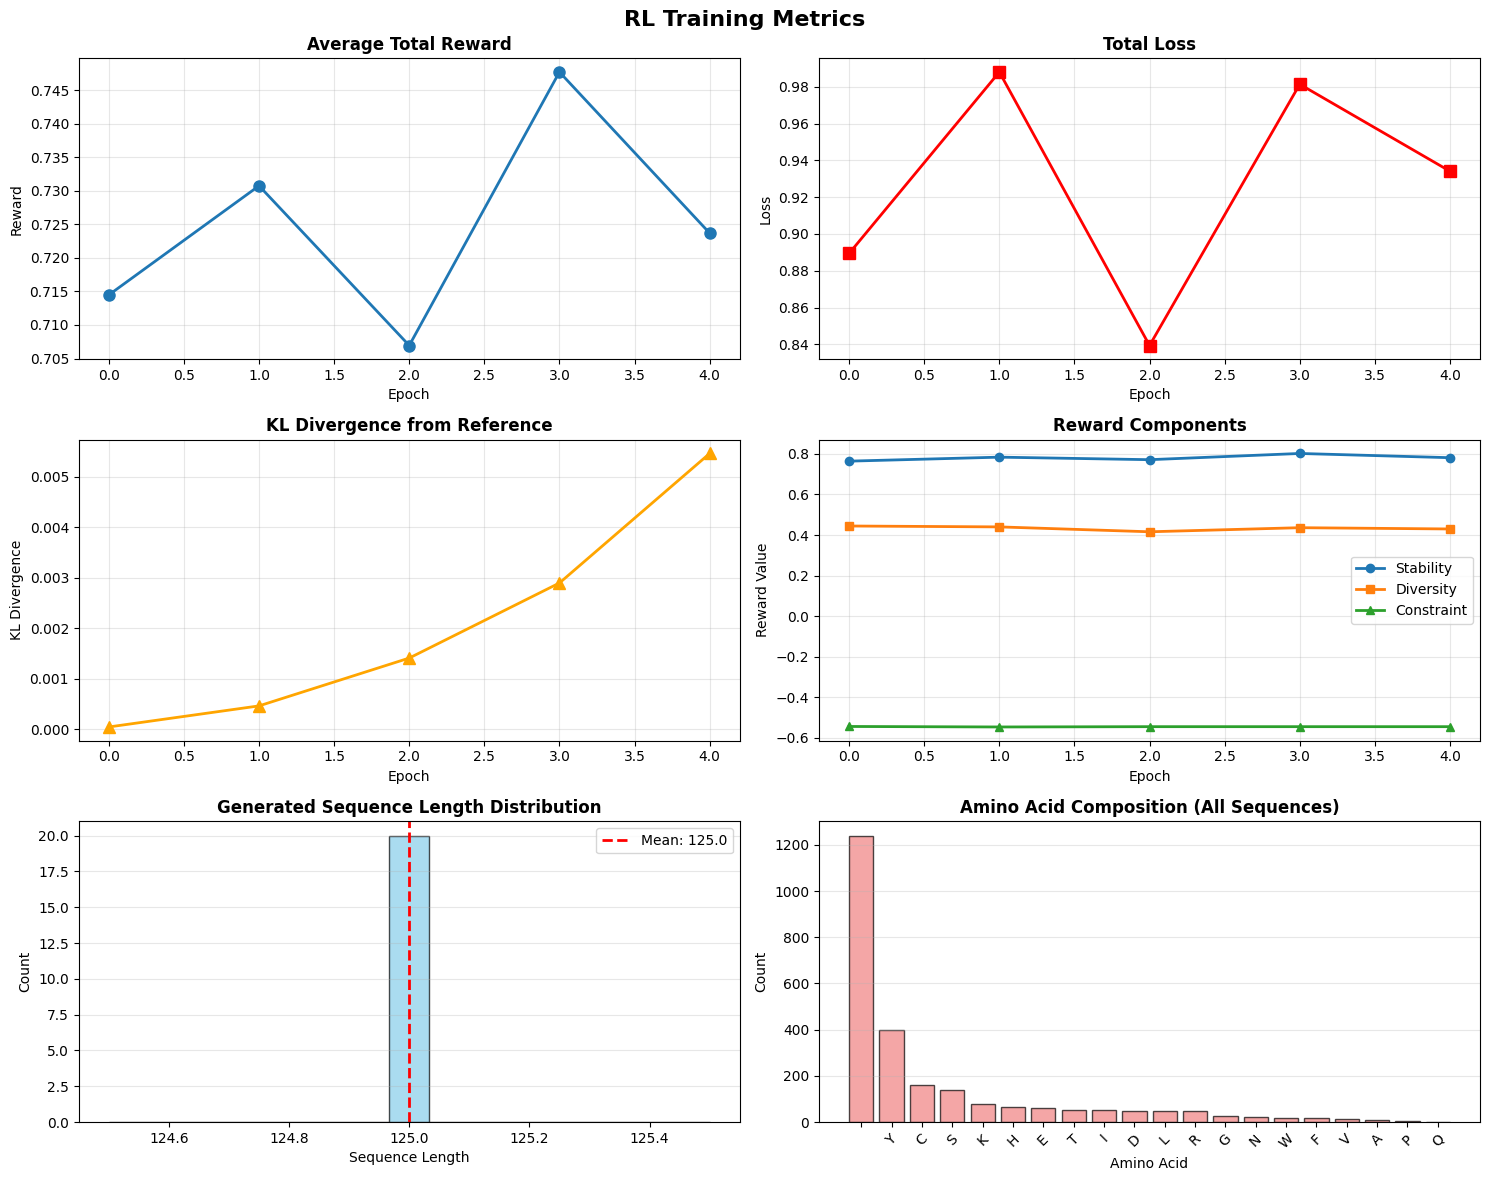

Saved reward distribution to 'reward_distribution.png'


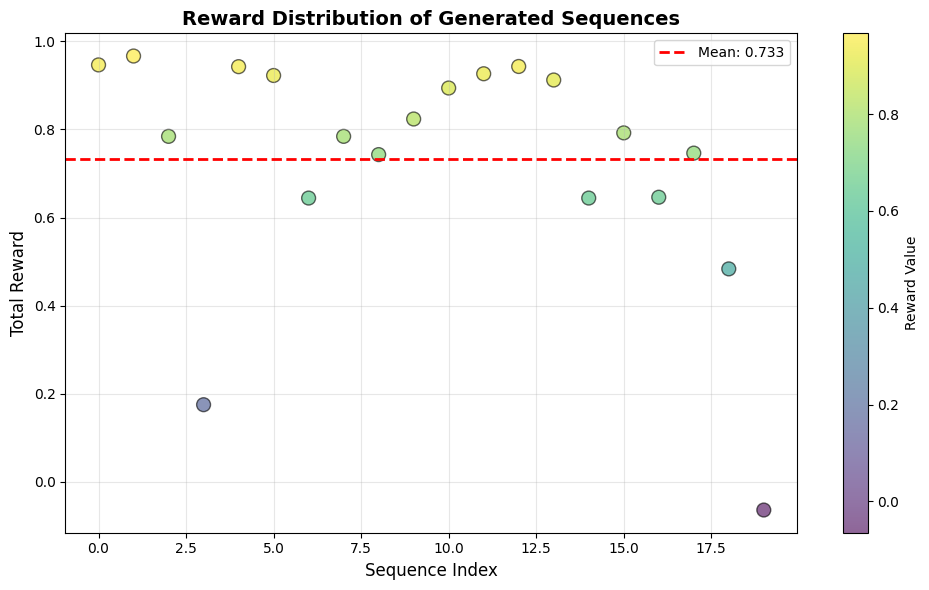

In [19]:
print("\n" + "="*80)
print("Creating Visualizations")
print("="*80)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('RL Training Metrics', fontsize=16, fontweight='bold')


axes[0, 0].plot(metrics['rewards'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_title('Average Total Reward', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].plot(metrics['total_loss'], marker='s', color='red', linewidth=2, markersize=8)
axes[0, 1].set_title('Total Loss', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)


axes[1, 0].plot(metrics['kl_divergence'], marker='^', color='orange', linewidth=2, markersize=8)
axes[1, 0].set_title('KL Divergence from Reference', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('KL Divergence')
axes[1, 0].grid(True, alpha=0.3)


epochs = range(len(metrics['stability_rewards']))
axes[1, 1].plot(epochs, metrics['stability_rewards'], marker='o', label='Stability', linewidth=2)
axes[1, 1].plot(epochs, metrics['diversity_rewards'], marker='s', label='Diversity', linewidth=2)
axes[1, 1].plot(epochs, metrics['constraint_rewards'], marker='^', label='Constraint', linewidth=2)
axes[1, 1].set_title('Reward Components', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Reward Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)


final_lengths = [len(s) for s in final_sequences_str]
axes[2, 0].hist(final_lengths, bins=15, edgecolor='black', alpha=0.7, color='skyblue')
axes[2, 0].axvline(np.mean(final_lengths), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(final_lengths):.1f}')
axes[2, 0].set_title('Generated Sequence Length Distribution', fontweight='bold')
axes[2, 0].set_xlabel('Sequence Length')
axes[2, 0].set_ylabel('Count')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3, axis='y')


aa_composition = {}
for seq in final_sequences_str:
    for aa in seq:
        aa_composition[aa] = aa_composition.get(aa, 0) + 1

aa_sorted = sorted(aa_composition.items(), key=lambda x: x[1], reverse=True)
aas, counts = zip(*aa_sorted) if aa_sorted else ([], [])
axes[2, 1].bar(aas, counts, edgecolor='black', alpha=0.7, color='lightcoral')
axes[2, 1].set_title('Amino Acid Composition (All Sequences)', fontweight='bold')
axes[2, 1].set_xlabel('Amino Acid')
axes[2, 1].set_ylabel('Count')
axes[2, 1].grid(True, alpha=0.3, axis='y')
axes[2, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('rl_training_results.png', dpi=300, bbox_inches='tight')
print(" Saved training plots to 'rl_training_results.png'")
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
all_rewards, all_components = reward_calculator.compute_rewards(final_sequences_str)

ax.scatter(range(len(all_rewards)), all_rewards.numpy(), 
          s=100, alpha=0.6, c=all_rewards.numpy(), cmap='viridis', edgecolors='black')
ax.axhline(all_rewards.mean().item(), color='red', linestyle='--', 
          linewidth=2, label=f'Mean: {all_rewards.mean().item():.3f}')
ax.set_title('Reward Distribution of Generated Sequences', fontsize=14, fontweight='bold')
ax.set_xlabel('Sequence Index', fontsize=12)
ax.set_ylabel('Total Reward', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.colorbar(ax.collections[0], ax=ax, label='Reward Value')
plt.tight_layout()
plt.savefig('reward_distribution.png', dpi=300, bbox_inches='tight')
print("Saved reward distribution to 'reward_distribution.png'")
plt.show()

In [32]:
print("\n" + "="*80)
print("Saving Results")
print("="*80)

model.save_pretrained("./esm2_rl_finetuned")
tokenizer.save_pretrained("./esm2_rl_finetuned")
print("Saved fine-tuned model to './esm2_rl_finetuned'")


df = pd.DataFrame({
    'sequence': final_sequences_str,
    'length': [len(s) for s in final_sequences_str],
    'total_reward': all_rewards.numpy(),
    'stability': all_components['stability'].numpy(),
    'diversity': all_components['diversity'].numpy(),
    'constraint': all_components['constraint'].numpy()
})
df.to_csv('generated_sequences.csv', index=False)
print("Saved sequences to 'generated_sequences.csv'")


metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('training_metrics.csv', index=False)
print("Saved training metrics to 'training_metrics.csv'")



Saving Results
Saved fine-tuned model to './esm2_rl_finetuned'
Saved sequences to 'generated_sequences.csv'
Saved training metrics to 'training_metrics.csv'
